
File: plate2ex_angleNeg45ex_len10_t5_Fri_Jun_20_19_17_27_2025.csv
1. Linear Start         : t = 4.036s, toe_y = -0.1253
2. Calib Zero (1s)      : t = 5.037s, toe_y = -0.1320
3. Intrusion End (95%)  : t = 12.635s, toe_y = -0.1817
4. Fy Steep End         : t = 16.483s, toe_y = -0.1846
5. Extrude Start (+1s)  : t = 17.483s, toe_y = -0.1786
6. Extrude End          : t = 23.933s, toe_y = -0.1320

Fx slope (intrusion): -1.43499 N/cm
Fy slope (intrusion): -1.02740 N/cm
Fx slope (extrusion): 0.13514 N/cm
Fy slope (extrusion): -0.04499 N/cm


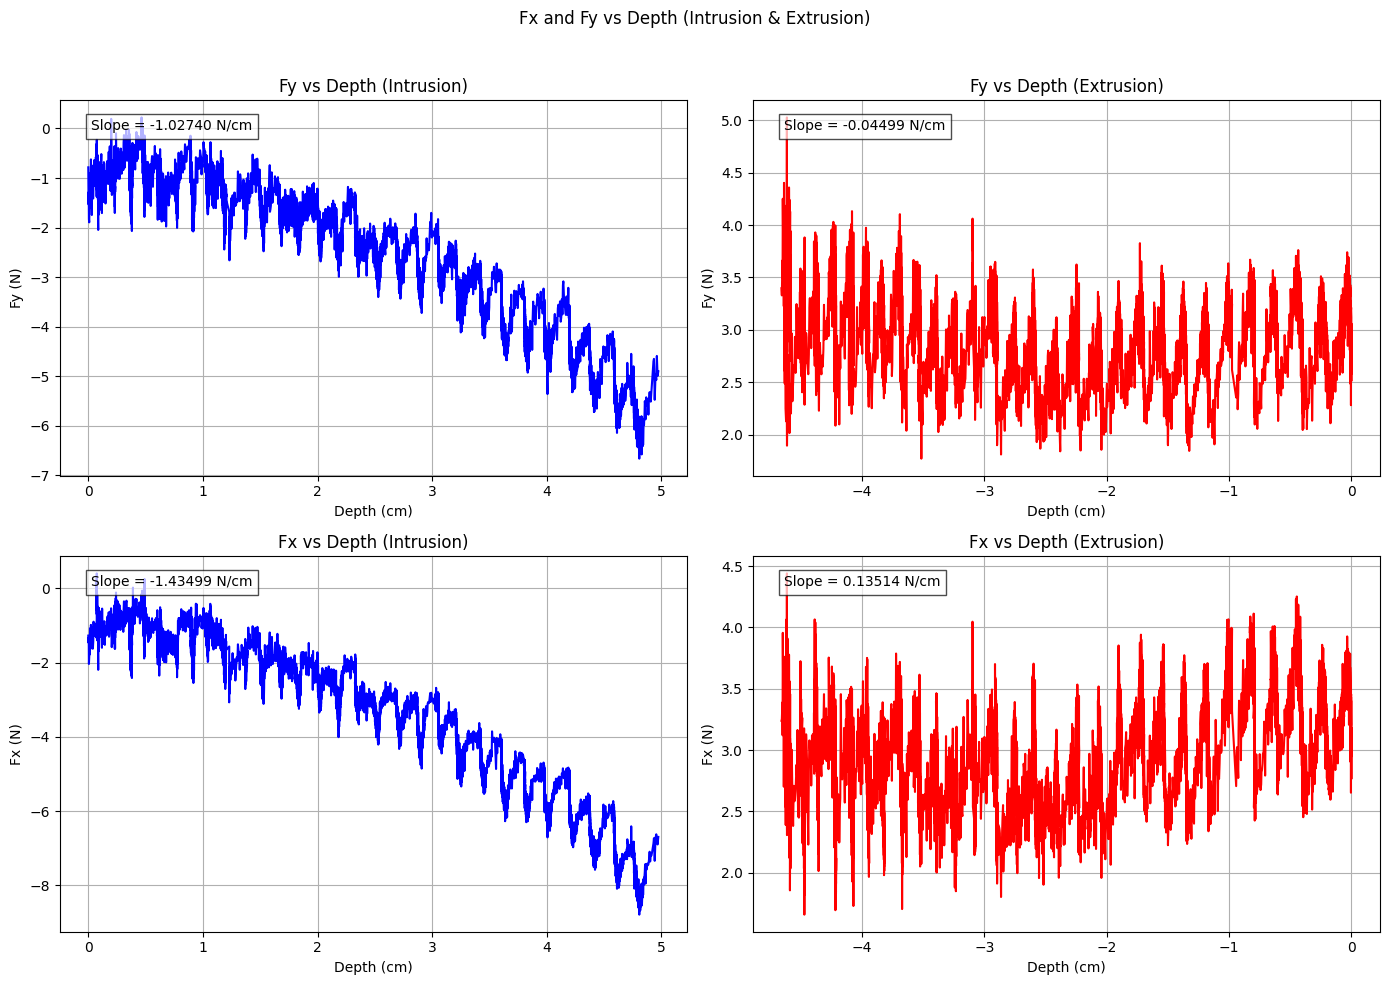

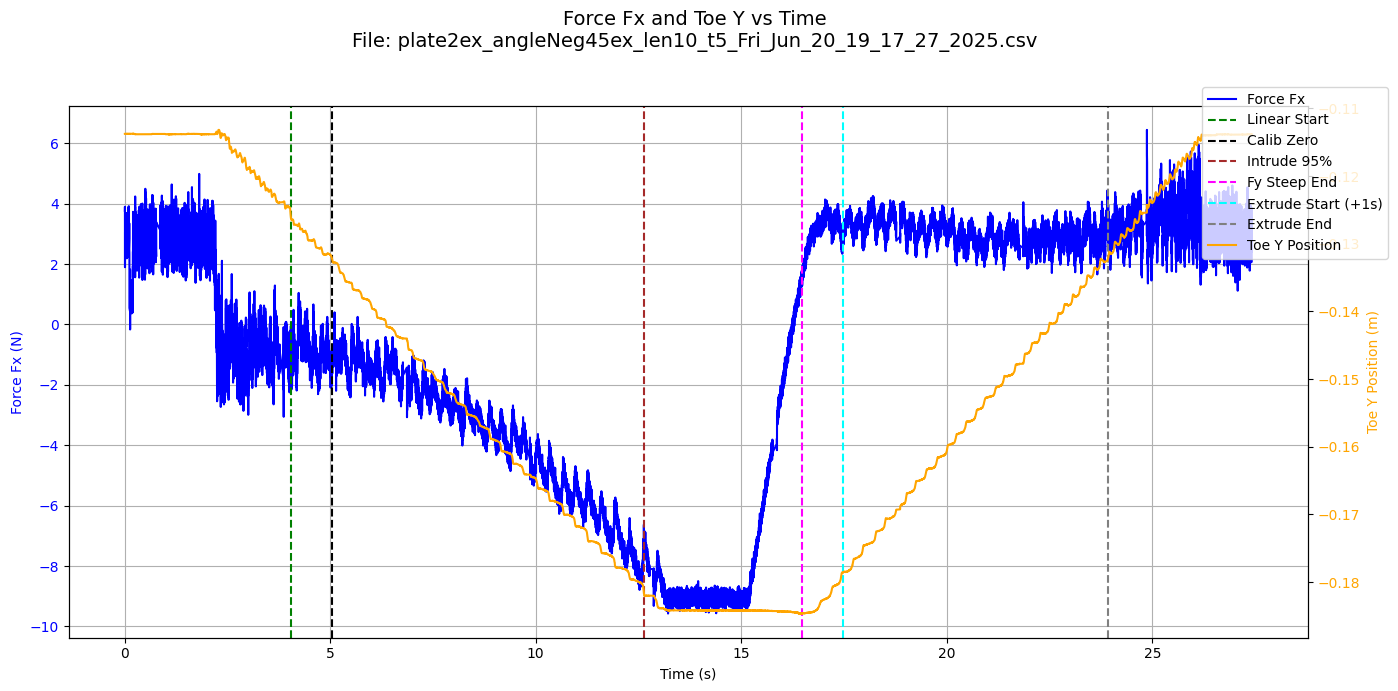

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import linregress
import os

def butter_lowpass_filter(data, cutoff, fs, order=3):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low')
    return filtfilt(b, a, data)

def process_file(file_path):
    df = pd.read_csv(file_path, skiprows=2)

    time_col = 'time'
    toe_y_col = 'toe_position_y'
    fy_col = 'toeforce_y'
    fx_col = 'toeforce_x'

    fs = 1 / np.mean(np.diff(df[time_col]))
    df['Fy_filtered'] = butter_lowpass_filter(df[fy_col], cutoff=3.0, fs=fs)
    df['dFy_dt'] = np.gradient(df['Fy_filtered'], df[time_col])
    df['dToeY_dt'] = np.gradient(df[toe_y_col], df[time_col])

    min_toe_idx = df[toe_y_col].idxmin()

    window_check = 5
    rise_thresh = 1.0
    steep_start_idx = next((i for i in range(min_toe_idx, len(df) - window_check)
                            if np.all(df['dFy_dt'].iloc[i:i + window_check] > rise_thresh)), min_toe_idx)

    flat_thresh = 0.2
    flat_window = 5
    Fy_start = df['Fy_filtered'].iloc[steep_start_idx]
    Fy_max = df['Fy_filtered'].iloc[steep_start_idx:].max()
    Fy_90pct = Fy_start + 0.9 * (Fy_max - Fy_start)

    steep_end_idx = next((i + flat_window for i in range(steep_start_idx + window_check, len(df) - flat_window)
                          if df['Fy_filtered'].iloc[i] >= Fy_90pct and
                          np.all(np.abs(df['dFy_dt'].iloc[i:i + flat_window]) < flat_thresh)), min_toe_idx)

    slope_window = 10
    slopes = [(i, np.polyfit(df[time_col].iloc[i:i + slope_window],
                             df[toe_y_col].iloc[i:i + slope_window], 1)[0])
              for i in range(0, min_toe_idx - slope_window)]
    linear_start_idx, _ = min(slopes, key=lambda x: x[1])

    ref_time = df[time_col].iloc[linear_start_idx] + 1.0
    calib_zero_idx = df.index[df[time_col] >= ref_time][0]
    calibrated_y = df[toe_y_col].iloc[calib_zero_idx]

    toe_y_min = df[toe_y_col].iloc[min_toe_idx]
    toe_y_start = df[toe_y_col].iloc[linear_start_idx]
    depth_thresh = toe_y_min + 0.05 * (toe_y_start - toe_y_min)
    depth_95_idx = df[toe_y_col].iloc[linear_start_idx:min_toe_idx][
        df[toe_y_col].iloc[linear_start_idx:min_toe_idx] < depth_thresh].index[0]

    extrude_start_time = df[time_col].iloc[steep_end_idx] + 1.0
    extrude_start_idx = df.index[df[time_col] >= extrude_start_time][0]

    post_df = df.iloc[extrude_start_idx:]
    depth_diff = np.abs(post_df[toe_y_col] - calibrated_y)
    zero_depth_idx = (depth_diff[depth_diff < 0.001].idxmin()
                      if (depth_diff < 0.001).any()
                      else depth_diff.idxmin())

    # Convert depth to cm 
    df['depth'] = (calibrated_y - df[toe_y_col]) * 100

    df_intrude = df.loc[calib_zero_idx:depth_95_idx].copy()
    df_extrude = df.loc[extrude_start_idx:zero_depth_idx].copy()
    df_extrude['depth'] = df_extrude['depth'] - df_extrude['depth'].iloc[0]  

    # Convert slopes from N/m to N/cm
    fx_slope_i, _, _, _, _ = linregress(df_intrude['depth'], df_intrude[fx_col])
    fy_slope_i, _, _, _, _ = linregress(df_intrude['depth'], df_intrude[fy_col])
    fx_slope_e, _, _, _, _ = linregress(df_extrude['depth'], df_extrude[fx_col])
    fy_slope_e, _, _, _, _ = linregress(df_extrude['depth'], df_extrude[fy_col])

    
    print(f"\nFile: {os.path.basename(file_path)}")
    print(f"1. Linear Start         : t = {df[time_col].iloc[linear_start_idx]:.3f}s, toe_y = {df[toe_y_col].iloc[linear_start_idx]:.4f}")
    print(f"2. Calib Zero (1s)      : t = {df[time_col].iloc[calib_zero_idx]:.3f}s, toe_y = {df[toe_y_col].iloc[calib_zero_idx]:.4f}")
    print(f"3. Intrusion End (95%)  : t = {df[time_col].iloc[depth_95_idx]:.3f}s, toe_y = {df[toe_y_col].iloc[depth_95_idx]:.4f}")
    print(f"4. Fy Steep End         : t = {df[time_col].iloc[steep_end_idx]:.3f}s, toe_y = {df[toe_y_col].iloc[steep_end_idx]:.4f}")
    print(f"5. Extrude Start (+1s)  : t = {df[time_col].iloc[extrude_start_idx]:.3f}s, toe_y = {df[toe_y_col].iloc[extrude_start_idx]:.4f}")
    print(f"6. Extrude End          : t = {df[time_col].iloc[zero_depth_idx]:.3f}s, toe_y = {df[toe_y_col].iloc[zero_depth_idx]:.4f}")

    print(f"\nFx slope (intrusion): {fx_slope_i:.5f} N/cm")
    print(f"Fy slope (intrusion): {fy_slope_i:.5f} N/cm")
    print(f"Fx slope (extrusion): {fx_slope_e:.5f} N/cm")
    print(f"Fy slope (extrusion): {fy_slope_e:.5f} N/cm")

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    axs[0, 0].plot(df_intrude['depth'], df_intrude[fy_col], 'b')
    axs[0, 0].set_title("Fy vs Depth (Intrusion)")
    axs[0, 0].set_xlabel("Depth (cm)")
    axs[0, 0].set_ylabel("Fy (N)")
    axs[0, 0].grid()
    axs[0, 0].text(0.05, 0.95, f"Slope = {fy_slope_i:.5f} N/cm", transform=axs[0, 0].transAxes,
                   verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

    axs[0, 1].plot(df_extrude['depth'], df_extrude[fy_col], 'r')
    axs[0, 1].set_title("Fy vs Depth (Extrusion)")
    axs[0, 1].set_xlabel("Depth (cm)")
    axs[0, 1].set_ylabel("Fy (N)")
    axs[0, 1].grid()
    axs[0, 1].text(0.05, 0.95, f"Slope = {fy_slope_e:.5f} N/cm", transform=axs[0, 1].transAxes,
                   verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

    axs[1, 0].plot(df_intrude['depth'], df_intrude[fx_col], 'b')
    axs[1, 0].set_title("Fx vs Depth (Intrusion)")
    axs[1, 0].set_xlabel("Depth (cm)")
    axs[1, 0].set_ylabel("Fx (N)")
    axs[1, 0].grid()
    axs[1, 0].text(0.05, 0.95, f"Slope = {fx_slope_i:.5f} N/cm", transform=axs[1, 0].transAxes,
                   verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

    axs[1, 1].plot(df_extrude['depth'], df_extrude[fx_col], 'r')
    axs[1, 1].set_title("Fx vs Depth (Extrusion)")
    axs[1, 1].set_xlabel("Depth (cm)")
    axs[1, 1].set_ylabel("Fx (N)")
    axs[1, 1].grid()
    axs[1, 1].text(0.05, 0.95, f"Slope = {fx_slope_e:.5f} N/cm", transform=axs[1, 1].transAxes,
                   verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

    plt.suptitle("Fx and Fy vs Depth (Intrusion & Extrusion)")
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    fig2, ax1 = plt.subplots(figsize=(14, 7))
    ax2 = ax1.twinx()

    ax1.plot(df[time_col], df[fx_col], color='blue', label='Force Fx')
    ax2.plot(df[time_col], df[toe_y_col], color='orange', label='Toe Y Position')

    key_indices = [linear_start_idx, calib_zero_idx, depth_95_idx, steep_end_idx, extrude_start_idx, zero_depth_idx]
    key_labels = ['Linear Start', 'Calib Zero', 'Intrude 95%', 'Fy Steep End', 'Extrude Start (+1s)', 'Extrude End']
    key_colors = ['green', 'black', 'brown', 'magenta', 'cyan', 'gray']

    for idx, label, color in zip(key_indices, key_labels, key_colors):
        ax1.axvline(df[time_col].iloc[idx], linestyle='--', color=color, label=label)

    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Force Fx (N)", color='blue')
    ax2.set_ylabel("Toe Y Position (m)", color='orange')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='orange')

    fig2.suptitle(f"Force Fx and Toe Y vs Time\nFile: {os.path.basename(file_path)}", fontsize=14)
    fig2.legend(loc='upper right', bbox_to_anchor=(1, 0.88))
    ax1.grid(True)
    fig2.tight_layout(rect=[0, 0, 1, 0.95])

    plt.show()

process_file(r"C:\Users\Tarunika P\Desktop\Summer '25 Intern\USC\LASSIE\LASSIE_DataForHeatMap\LASSIE_DataForHeatMap\plate2\plate2ex_angleneg45\plate2ex_angleNeg45ex_len10_t5_Fri_Jun_20_19_17_27_2025.csv")
